In [43]:
import xscen as xs
from xscen.config import CONFIG, load_config

import xclim as xc
from xclim.core import dataflags

import xarray as xr
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import gridspec
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import seaborn as sns
import string
from dask.distributed import Client
import dask

import spirograph.matplotlib as sp
sp.utils.set_mpl_style('ouranos')



load_config('configuration/paths_ESPO-G_j.yml', 'configuration/config_ESPO-G_RDRS.yml', verbose=(__name__ == '__main__'), reset=True)
pcat = xs.ProjectCatalog(CONFIG['paths']['project_catalog'])
tdd = CONFIG['tdd']

INFO:xscen.config:Updated the config with configuration/paths_ESPO-G_j.yml.
INFO:xscen.config:Updated the config with configuration/config_ESPO-G_RDRS.yml.


# Health checks

In [161]:
import dask
dask.config.set({'logging.distributed': 'error'})
#,silence_logs= True
with Client(n_workers=4, threads_per_worker=5, memory_limit="6GB", local_directory= '/exec/jlavoie/tmp_ic6/',
            dashboard_address=6786):
    dict_final = pcat.search(processing_level='final', domain='NAM-rdrs').to_dataset_dict(**tdd)
    
    # to make sure that everything has the same coords
    model_ds = dict_final[list(dict_final.keys())[0]]
    for i,ds in dict_final.items():
        print(i)
        for c in model_ds.coords:
            if not model_ds[c].equals(ds[c]):
                print(f"{c} is different.")
                
        xc.core.datachecks.check_daily(ds)
        
        if dataflags.temperature_extremely_high(ds['tasmax']).any().values:
            print('temperature_extremely_high')
        if dataflags.temperature_extremely_low(ds['tasmin'], thresh='100 K').any().values:
            print('temperature_extremely_low')
        if dataflags.negative_accumulation_values(ds['pr']).any().values:
            print('negative_accumulation_values')
        if dataflags.tasmax_below_tasmin(tasmax=ds['tasmax'], tasmin=ds['tasmin']).any().values:
            print('tasmax_below_tasmin')


--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


CMIP6_ScenarioMIP_NOAA-GFDL_GFDL-ESM4_ssp245_r1i1p1f1_global.NAM-rdrs.final.D
CMIP6_ScenarioMIP_CMCC_CMCC-ESM2_ssp245_r1i1p1f1_global.NAM-rdrs.final.D
CMIP6_ScenarioMIP_NIMS-KMA_KACE-1-0-G_ssp370_r1i1p1f1_global.NAM-rdrs.final.D
time is different.
CMIP6_ScenarioMIP_CSIRO-ARCCSS_ACCESS-CM2_ssp370_r1i1p1f1_global.NAM-rdrs.final.D
CMIP6_ScenarioMIP_INM_INM-CM5-0_ssp245_r1i1p1f1_global.NAM-rdrs.final.D
CMIP6_ScenarioMIP_MIROC_MIROC6_ssp370_r1i1p1f1_global.NAM-rdrs.final.D
CMIP6_ScenarioMIP_BCC_BCC-CSM2-MR_ssp370_r1i1p1f1_global.NAM-rdrs.final.D
CMIP6_ScenarioMIP_MPI-M_MPI-ESM1-2-LR_ssp245_r1i1p1f1_global.NAM-rdrs.final.D
CMIP6_ScenarioMIP_CSIRO_ACCESS-ESM1-5_ssp245_r1i1p1f1_global.NAM-rdrs.final.D
CMIP6_ScenarioMIP_NIMS-KMA_KACE-1-0-G_ssp245_r1i1p1f1_global.NAM-rdrs.final.D
time is different.
CMIP6_ScenarioMIP_NCC_NorESM2-LM_ssp370_r1i1p1f1_global.NAM-rdrs.final.D
CMIP6_ScenarioMIP_DKRZ_MPI-ESM1-2-HR_ssp370_r1i1p1f1_global.NAM-rdrs.final.D
CMIP6_ScenarioMIP_DKRZ_MPI-ESM1-2-HR_ssp245_r1i1p1

# maps

In [45]:
#load all properties from ref, sim, scen
import copy
def maps(option_id, option_region, option_var):
    "Load properties and measures and plot them."
    
    # get data from catalogue
    prop_ref = pcat.search( processing_level=['diag-ref-prop*', 'diag_ref_prop'], domain=option_region, variable=option_var).to_dask()[option_var]
    prop_sim = pcat.search(id= option_id, processing_level='diag-sim-prop*', domain=option_region, variable=option_var).to_dask()[option_var]
    prop_scen = pcat.search(id= option_id, processing_level='diag-scen-prop*', domain=option_region, variable=option_var).to_dask()[option_var]
    meas_sim_prop = pcat.search(id=option_id, processing_level='diag-sim-meas*', domain=option_region, variable=option_var).to_dask()[option_var]
    meas_scen_prop = pcat.search(id=option_id, processing_level='diag-scen-meas*', domain=option_region, variable=option_var).to_dask()[option_var]
    
    
    #transpose
    if 'corr_' in option_var:
        prop_ref=prop_ref.transpose()
        prop_sim=prop_sim.transpose()
        prop_scen=prop_scen.transpose()
        meas_sim_prop=meas_sim_prop.transpose()
        meas_scen_prop=meas_scen_prop.transpose()
        # force the right cbar
        prop_ref.name= prop_ref.name+ " pr"
        prop_sim.name=prop_sim.name+ " pr"
        prop_scen.name=prop_scen.name+ " pr"
        meas_sim_prop.name=meas_sim_prop.name+ " pr"
        meas_scen_prop.name=meas_scen_prop.name+ " pr"
    
    prop_long_name=prop_sim.attrs['long_name'] 
    meas_long_name=meas_sim_prop.attrs['long_name'] 
    # change units
    if prop_ref.attrs['units']=='kg m-2 s-1':
        prop_ref = xc.core.units.convert_units_to(prop_ref, 'mm d-1', context='hydro')
        prop_sim = xc.core.units.convert_units_to(prop_sim, 'mm d-1', context='hydro')
        prop_scen = xc.core.units.convert_units_to(prop_scen, 'mm d-1', context='hydro')
        meas_sim_prop = xc.core.units.convert_units_to(meas_sim_prop, 'mm d-1', context='hydro')
        meas_scen_prop = xc.core.units.convert_units_to(meas_scen_prop, 'mm d-1', context='hydro')
        
    if prop_ref.attrs['units']=='K':
        prop_ref = xc.core.units.convert_units_to(prop_ref, 'degC')
        prop_sim = xc.core.units.convert_units_to(prop_sim, 'degC')
        prop_scen = xc.core.units.convert_units_to(prop_scen, 'degC')
        
    #set colormap
    maxi_prop = max(prop_ref.max().values, prop_scen.max().values, prop_sim.max().values)
    mini_prop = min(prop_ref.min().values, prop_scen.min().values, prop_sim.min().values)
    maxi_meas = float(max(abs(meas_scen_prop).max().values, abs(meas_sim_prop).max().values))

    #plot
    fig = plt.figure(figsize=(15, 8))
    map_proj = ccrs.RotatedPole(pole_longitude=87.59703063964844,
                          pole_latitude=31.758316040039062,
                         )
    gs = gridspec.GridSpec(4, 3)
    ax0= fig.add_subplot(gs[1:3,0],projection=map_proj)
    ax1= fig.add_subplot(gs[:2,1],projection=map_proj)
    ax2= fig.add_subplot(gs[:2,2],projection=map_proj)
    ax3= fig.add_subplot(gs[2:,1],projection=map_proj)
    ax4= fig.add_subplot(gs[2:,2],projection=map_proj)

    plot_kw_prop=dict(add_colorbar=False, vmin=mini_prop,vmax=maxi_prop)
    plot_kw_meas=dict(add_colorbar=False, vmin=-maxi_meas,vmax=maxi_meas)
    features={ 'lakes':{'scale':'110m', 'edgecolor':'black', 'facecolor':'none'},'coastline':{'scale':'50m'}}
    #plot
    # deep copy until bug is fix TODO
    sp.gridmap(prop_ref, ax=ax0, plot_kw=plot_kw_prop, features=copy.deepcopy(features))
    sp.gridmap(prop_sim, ax=ax1, plot_kw=plot_kw_prop, features=copy.deepcopy(features))
    sp.gridmap(prop_scen, ax=ax3, plot_kw=plot_kw_prop, features=copy.deepcopy(features))
    sp.gridmap(meas_sim_prop, ax=ax2, plot_kw=plot_kw_meas,divergent=0, features=copy.deepcopy(features))
    sp.gridmap(meas_scen_prop, ax=ax4, plot_kw=plot_kw_meas,divergent=0, features=copy.deepcopy(features))

    #prop colorbar
    fig.subplots_adjust(bottom=0.1)
    cbar_ax = fig.add_axes([0.15, 0.01, 0.45, 0.03])
    cb1=fig.colorbar(ax0.get_children()[0], cax=cbar_ax,orientation='horizontal')
    cb1.set_label(label=f"{prop_long_name} ({prop_sim.attrs['units']})",size=15)
    cb1.ax.tick_params(axis='x', direction='out')
    cb1.outline.set_visible(False)
    
    #meas colorbar
    fig.subplots_adjust(bottom=0.1)
    cbar_ax = fig.add_axes([0.68, 0.01, 0.25, 0.03])
    cb2=fig.colorbar(ax2.get_children()[0], cax=cbar_ax,orientation='horizontal')
    cb2.set_label(label=f"{meas_long_name} ({meas_sim_prop.attrs['units']})",size=15)
    
    cb2.ax.tick_params(axis='x', direction='out')
    cb2.outline.set_visible(False)
    
    fs=15
    ax0.set_title(r'a) reference', fontsize=fs)
    ax1.set_title(r'b) original', fontsize=fs)
    ax2.set_title(r'c) original', fontsize=fs)
    ax3.set_title(r'd) bias-adjusted', fontsize=fs)
    ax4.set_title(r'e) bias-adjusted', fontsize=fs)
    fig.tight_layout(pad=5.0)
    return fig,[ax0,ax1,ax2,ax3,ax4], [cb1,cb2]
    

/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/dask/array/reductions.py:640: RuntimeWarning: All-NaN slice encountered
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/dask/array/reductions.py:640: RuntimeWarning: All-NaN slice encountered
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/dask/array/reductions.py:640: RuntimeWarning: All-NaN slice encountered
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/dask/array/reductions.py:611: RuntimeWarning: All-NaN slice encountered
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/dask/array/reductions.py:611: RuntimeWarning: All-NaN slice encountered
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/dask/array/reductions.py:611: RuntimeWarning: All-NaN slice encountered
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/dask/array/reductions.py:640: RuntimeWarning: All-NaN slice encountered
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/dask/array/reductions.py:640: RuntimeWarning: Al

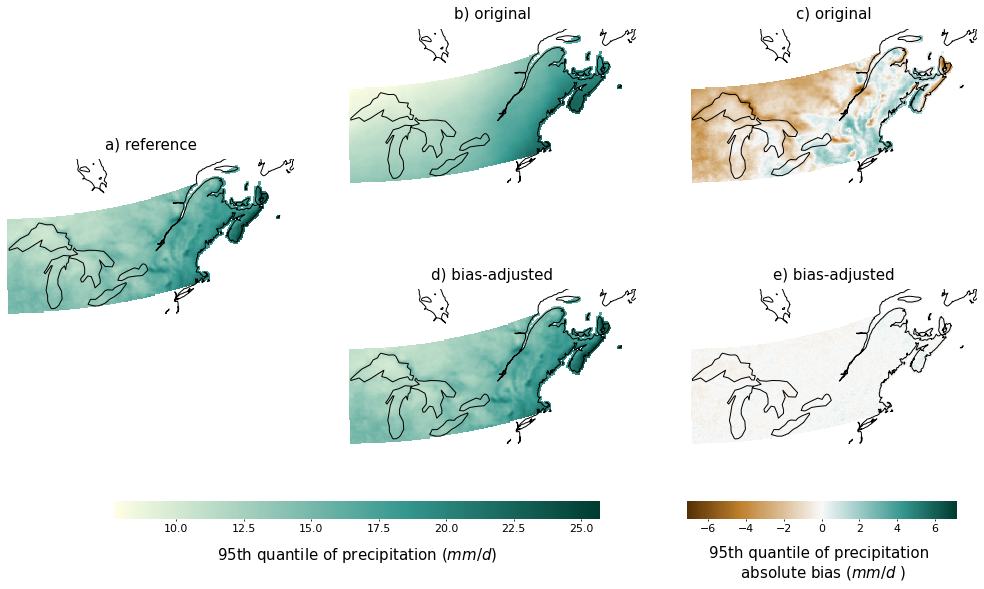

In [48]:
option_id ='CMIP6_ScenarioMIP_NIMS-KMA_KACE-1-0-G_ssp370_r1i1p1f1_global'
option_region = 'Magtogoek-rdrs'
option_var = 'q95_pr'
fig, axs, cbs=maps(option_id=option_id, option_region=option_region, option_var=option_var)
cbs[1].set_label("95th quantile of precipitation \n absolute bias "+r"($mm/d$ )", labelpad=12)
cbs[0].set_label("95th quantile of precipitation "+r"($mm/d$)", labelpad=12)
plt.savefig(f"{CONFIG['paths']['figures']}q95_pr.eps", format='eps',bbox_inches='tight')


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/dask/array/reductions.py:640: RuntimeWarning: All-NaN slice encountered
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/dask/array/reductions.py:640: RuntimeWarning: All-NaN slice encountered
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/dask/array/reductions.py:640: RuntimeWarning: All-NaN slice encountered
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/dask/array/reductions.py:611: RuntimeWarning: All-NaN slice encountered
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/dask/array/reductions.py:611: RuntimeWarning: All-NaN slice encountered
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/dask/array/reductions.py:611: RuntimeWarning: All-NaN slice encountered
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/dask/array/reductions.py:640: RuntimeWarning: All-NaN slice encountered
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/dask/array/reductions.py:640: RuntimeWarning: Al

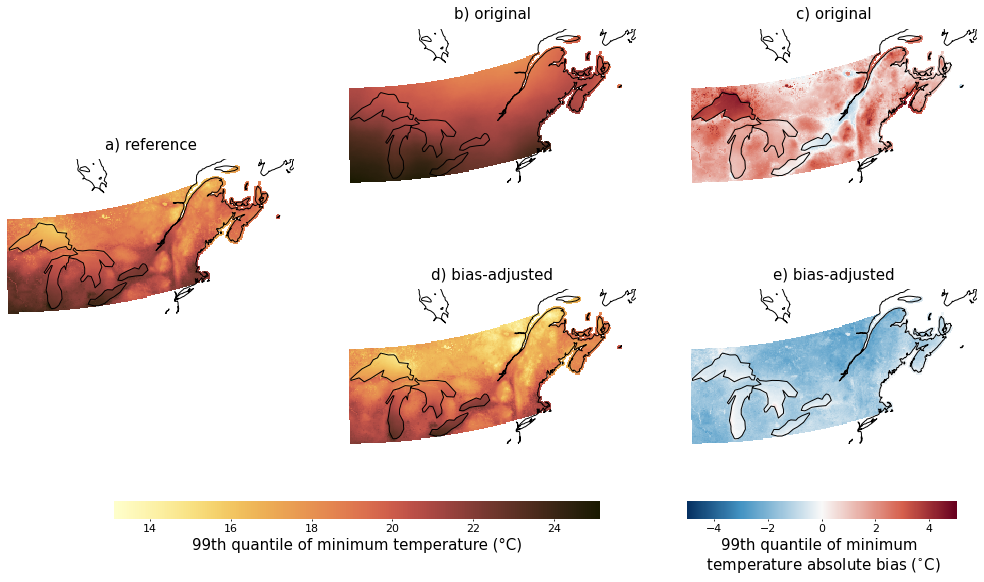

In [49]:
option_id ='CMIP6_ScenarioMIP_MIROC_MIROC6_ssp370_r1i1p1f1_global'
option_region = 'Magtogoek-rdrs'
option_var = 'q99_tasmin'
fig, axs, cbs=maps(option_id=option_id, option_region=option_region, option_var=option_var)
cbs[1].set_label("99th quantile of minimum \n temperature absolute bias "+r"($^{\circ}$C)")
plt.savefig(f"{CONFIG['paths']['figures']}q99_tasmin.eps", format='eps',bbox_inches='tight')

/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/dask/array/reductions.py:640: RuntimeWarning: All-NaN slice encountered
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/dask/array/reductions.py:640: RuntimeWarning: All-NaN slice encountered
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/dask/array/reductions.py:640: RuntimeWarning: All-NaN slice encountered
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/dask/array/reductions.py:611: RuntimeWarning: All-NaN slice encountered
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/dask/array/reductions.py:611: RuntimeWarning: All-NaN slice encountered
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/dask/array/reductions.py:611: RuntimeWarning: All-NaN slice encountered
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/dask/array/reductions.py:640: RuntimeWarning: All-NaN slice encountered
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/dask/array/reductions.py:640: RuntimeWarning: Al

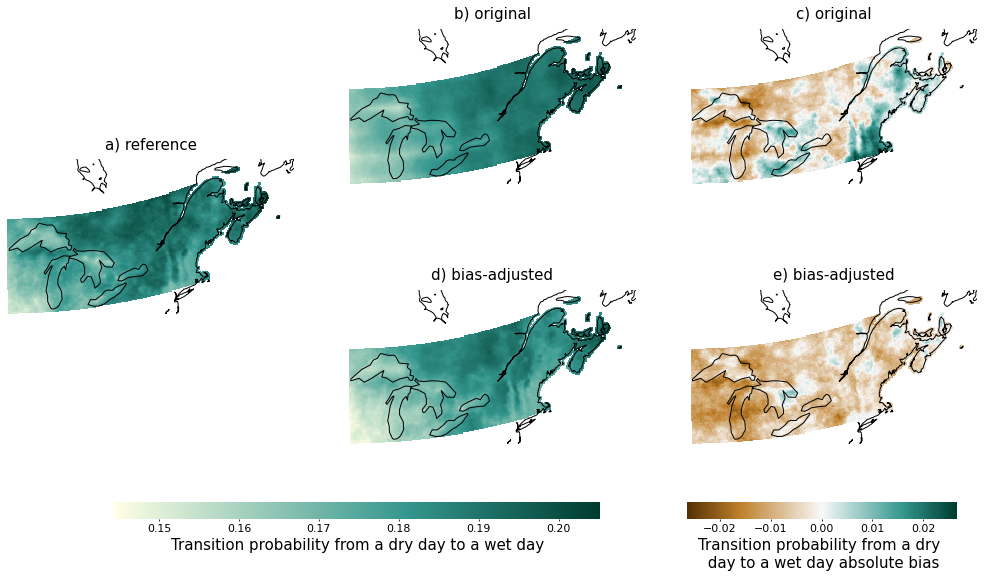

In [ ]:
option_id ='CMIP6_ScenarioMIP_CAS_FGOALS-g3_ssp370_r1i1p1f1_global'
option_region = 'Magtogoek-rdrs'
option_var = 'dry_wet_transition'
fig, axs, cbs=maps(option_id=option_id, option_region=option_region, option_var=option_var)
cbs[1].set_label("Transition probability from a dry \n day to a wet day absolute bias")
cbs[0].set_label("Transition probability from a dry day to a wet day")
plt.savefig(f"{CONFIG['paths']['figures']}dry_wet.eps", format='eps',bbox_inches='tight')

# heatmap


--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/spirograph/matplotlib/utils.py:142: UserWarning: Attribute "long_name" not found.


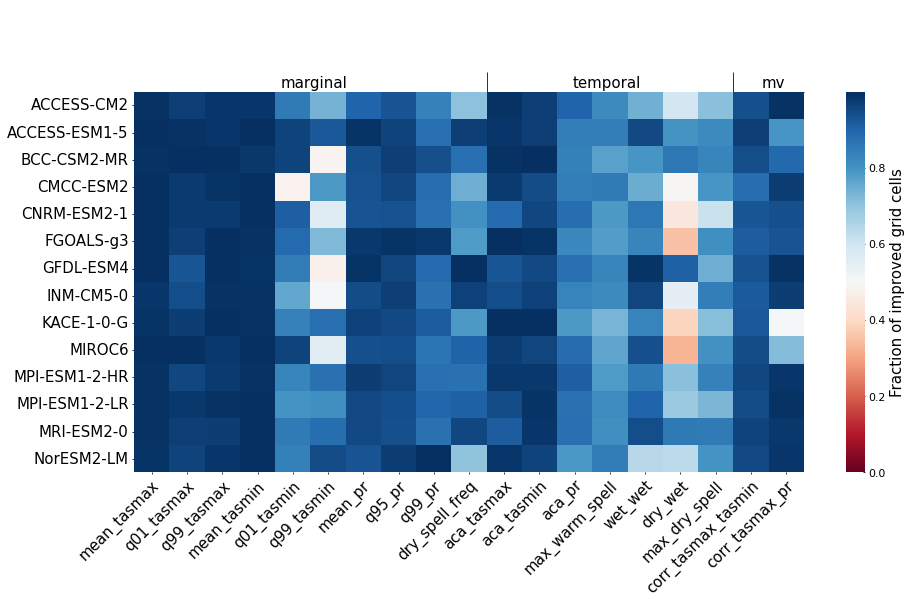

In [51]:
#assemble all improved into 1 dataset
dict_hm = pcat.search(processing_level='diag-improved', domain= 'Magtogoek-rdrs', experiment='ssp370').to_dataset_dict()
dict_hm= {ds.attrs['cat:source']:ds for name,ds in dict_hm.items()}
ds_merge=xs.diagnostics.measures_improvement_2d(dict_hm)

# select the right order
# ordered list of properties
order = [
        'mean_tasmax','q01_tasmax', 'q99_tasmax', 'mean_tasmin','q01_tasmin','q99_tasmin',
    'mean_pr','q95_pr','q99_pr','dry_spell_freq', 
    'aca_tasmax', 'aca_tasmin','aca_pr',
         'maximum_length_of_warm_spell','wet_wet_transition', 'dry_wet_transition', 'maximum_length_of_dry_spell',
        'corr_tasmax_tasmin','corr_tasmax_pr',
        ]
# name I want to show up on plot
better_name = [
        'mean_tasmax','q01_tasmax', 'q99_tasmax', 'mean_tasmin','q01_tasmin','q99_tasmin',
    'mean_pr','q95_pr','q99_pr','dry_spell_freq', 
    'aca_tasmax', 'aca_tasmin','aca_pr',
         'max_warm_spell','wet_wet', 'dry_wet', 'max_dry_spell',
        'corr_tasmax_tasmin','corr_tasmax_pr',
        ]
# put in the right order
ds_merge= ds_merge.sel(properties=order, realization = np.sort(ds_merge.realization.values))
# change the name
ds_merge['properties']=better_name

ax=sp.heatmap(ds_merge, fig_kw={'figsize':(15,7)},divergent=0.5 , plot_kw={'vmin': 0})
ax.set_xlabel("") # get rid of labels
ax.set_ylabel("")
plt.xticks(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


y=1.025
plt.annotate(r"marginal",fontsize=15,xy=(0.26, y), xycoords='figure fraction')
plt.annotate(r"temporal",fontsize=15,xy=(0.53, y), xycoords='figure fraction')
plt.annotate(r"mv",fontsize=15,xy=(0.705, y), xycoords='figure fraction')
ax2 = plt.gca().secondary_xaxis('top')
ax2.tick_params(axis='x',length=20, direction="out")
ax2.set_xticks([10,17])
plt.setp(ax2.get_xticklabels(), visible=False)


#cb = plt.colorbar()
ax.collections[-1].colorbar.set_label(label='Fraction of improved grid cells',size=15)
plt.savefig(f"{CONFIG['paths']['figures']}imp.eps", format='eps',bbox_inches='tight')

In [83]:
# get mean IMP 
print('q95_pr',ds_merge.sel(properties='q95_pr').improved_grid_points.mean(dim='realization').values)
print('aca_pr',ds_merge.sel(properties='aca_pr').improved_grid_points.mean(dim='realization').values)
print('aca_tasmax', ds_merge.sel(properties='aca_tasmax').improved_grid_points.mean(dim='realization').values)

print('maximum_length_of_warm_spell',ds_merge.sel(properties='max_warm_spell').improved_grid_points.mean(dim='realization').values)
print('maximum_length_of_dry_spell',ds_merge.sel(properties='max_dry_spell').improved_grid_points.mean(dim='realization').values)
print('wet_wet_transition',ds_merge.sel(properties='wet_wet').improved_grid_points.mean(dim='realization').values)
print('dry_wet_transition',ds_merge.sel(properties='dry_wet').improved_grid_points.mean(dim='realization').values)

print('corr_tasmax_tasmin',ds_merge.sel(properties='corr_tasmax_tasmin').improved_grid_points.mean(dim='realization').values)
print('corr_tasmax_pr',ds_merge.sel(properties='corr_tasmax_pr').improved_grid_points.mean(dim='realization').values)

q95_pr 0.9551301650273304
aca_pr 0.8545552166682823
aca_tasmax 0.9642577498713637
maximum_length_of_warm_spell 0.8032983094579379
maximum_length_of_dry_spell 0.7767880446535769
wet_wet_transition 0.8556924361852065
dry_wet_transition 0.614035153133133
corr_tasmax_tasmin 0.9360882631488677
corr_tasmax_pr 0.9045183036413397


# Domain

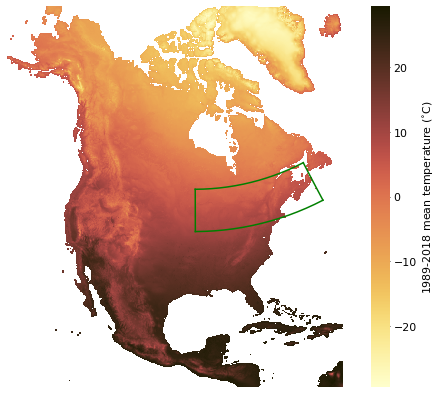

In [52]:
# This is the map projection we want to plot *onto*
import matplotlib.patches as mpatches
map_proj = ccrs.RotatedPole(pole_longitude=87.59703063964844,
                          pole_latitude=31.758316040039062,
                         )

# something to plot as the domain
ds = pcat.search(processing_level='ensemble-climatology', domain='NAM-rdrs',
                 variable='tg_mean_p50', experiment='ssp370').to_dataset().sel(time='1989-01-01')['tg_mean_p50']

ds = xc.core.units.convert_units_to(ds,'degC')

ax= sp.gridmap(ds.squeeze(),
               fig_kw=dict(figsize=(10,7)),
               projection=map_proj,
               #show_time=True, TODO: add when can choose loc
               #features={'coastline':{'scale':'50m'},
               #          'lakes':{'scale':'110m','edgecolor':'black','facecolor':'none'}}
              )



#rectangle for spatial subregion magtogoek-rdrs
lat_bnds=  [ 41.4, 49.4]  
lon_bnds= [ -92.2, -59.8 ] 

color='green'
ax.plot(np.linspace(lon_bnds[0], lon_bnds[1],15), np.linspace(lat_bnds[0], lat_bnds[0],15),
         color=color, linestyle='-', transform=ccrs.PlateCarree()
         )

ax.plot(np.linspace(lon_bnds[0], lon_bnds[1],15), np.linspace(lat_bnds[1], lat_bnds[1],15),
         color=color, linestyle='-',transform=ccrs.PlateCarree()
         )

ax.plot(np.linspace(lon_bnds[0], lon_bnds[0],15), np.linspace(lat_bnds[0], lat_bnds[1],15),
         color=color, linestyle='-',transform=ccrs.PlateCarree()
         )

ax.plot(np.linspace(lon_bnds[1], lon_bnds[1],15), np.linspace(lat_bnds[0], lat_bnds[1],15),
         color=color, linestyle='-',transform=ccrs.PlateCarree()
         )

ax.collections[-1].colorbar.outline.set_visible(False)
ax.set_title('')
ax.collections[-1].colorbar.set_label(r'1989-2018 mean temperature ($^{\circ}$C)')
plt.savefig(f"{CONFIG['paths']['figures']}domain.eps", format='eps',bbox_inches='tight')

# ensemble variability


--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


INFO:xscen.ensembles:Creating ensemble with 14 simulations and calculating ensemble_percentiles.



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


INFO:xscen.ensembles:Creating ensemble with 14 simulations and calculating ensemble_percentiles.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/spirograph/matplotlib/utils.py:142: UserWarning: Attribute "None" not found.



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


INFO:xscen.ensembles:Creating ensemble with 14 simulations and calculating ensemble_percentiles.



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


INFO:xscen.ensembles:Creating ensemble with 14 simulations and calculating ensemble_percentiles.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/spirograph/matplotlib/utils.py:142: UserWarning: Attribute "None" not found.



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


INFO:xscen.ensembles:Creating ensemble with 14 simulations and calculating ensemble_percentiles.



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


INFO:xscen.ensembles:Creating ensemble with 14 simulations and calculating ensemble_percentiles.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/spirograph/matplotlib/utils.py:142: UserWarning: Attribute "None" not found.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/spirograph/matplotlib/utils.py:633: UserWarning: No spaces, points or colons to break line at.


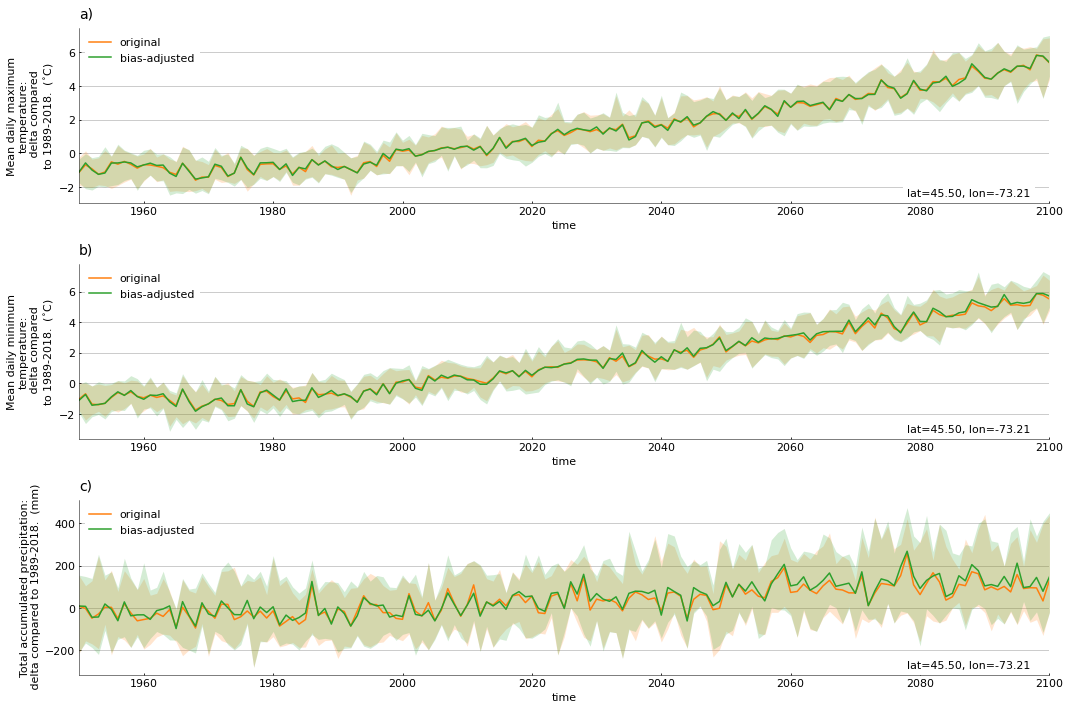

In [90]:
lat= 45.5
lon=-73.5
lat=45.503895
var = 'tx_mean'

func= {'prcptot': 'precip_accumulation',
      'tx_mean':'tx_mean',
      'tn_mean':'tn_mean'}
fig, axs = plt.subplots(3,1, figsize=(15,10))
with xr.set_options(keep_attrs=True):
    for i,(var,title) in enumerate(zip(['tx_mean', 'tn_mean', 'prcptot'],['a)','b)', 'c)'])):
        #get variable and compute indicators
        sim_dict = pcat.search(processing_level='regridded', experiment='ssp370', domain ='QC-rdrs').to_dataset_dict()    
        sim_dict= {i: getattr(xc.atmos, func[var])(ds=ds.where(ds.lat==lat, drop=True)).drop_vars('loc').squeeze()
                   for i,ds in sim_dict.items()}
        # compute anomaly
        sim_dict = {i: ds - ds.sel(time=slice('1989','2018')).mean(dim='time') for i,ds in sim_dict.items()}
        # ensemble stats
        ens_sim = xs.ensembles.ensemble_stats(
                            datasets=sim_dict,
                            statistics={"ensemble_percentiles": {'split': False}},
                            common_attrs_only=False,
                        )[var].to_dataset()


        #same as above but for scen
        scen_dict = pcat.search(processing_level='indicators', domain='QC-rdrs',
                                variable=var, xrfreq='AS-JAN', experiment='ssp370').to_dataset_dict()
        scen_dict = {i: ds.where(ds.lat==lat, drop=True).squeeze() for i,ds in scen_dict.items()}
        scen_dict = {i: ds - ds.sel(time=slice('1989','2018')).mean(dim='time') for i,ds in scen_dict.items()}
        ens_scen = xs.ensembles.ensemble_stats(
                            datasets=scen_dict,
                            statistics={"ensemble_percentiles": {'split': False}},
                            common_attrs_only=False,
                        )[var].to_dataset()
        
        ens_sim[var].attrs['long_name']= f"{ens_sim[var].attrs['long_name']}:\n delta compared to 1989-2018. "

        if var in ['tx_mean', 'tn_mean']:
            ens_sim[var].attrs['units']=r"$^{\circ}$C"
        
        sp.timeseries({'original': ens_sim[var], 'bias-adjusted': ens_scen[var]},
                  ax =axs[i],
                  use_attrs={'title':None},
                  plot_kw={'original': {'color':'tab:orange',}, 'bias-adjusted': {'color':'tab:green'}})

        sns.move_legend(axs[i], loc='upper left', )
        axs[i].set_title(title, loc='left')
    fig.tight_layout()
plt.savefig(f"{CONFIG['paths']['figures']}ens_var.pdf",bbox_inches='tight')


--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


INFO:xscen.ensembles:Creating ensemble with 14 simulations and calculating ensemble_percentiles.



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


INFO:xscen.ensembles:Creating ensemble with 14 simulations and calculating ensemble_percentiles.


tx_mean 0.34976647440590647

--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


INFO:xscen.ensembles:Creating ensemble with 14 simulations and calculating ensemble_percentiles.



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


INFO:xscen.ensembles:Creating ensemble with 14 simulations and calculating ensemble_percentiles.


tn_mean 0.132672775689433

--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


INFO:xscen.ensembles:Creating ensemble with 14 simulations and calculating ensemble_percentiles.



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


INFO:xscen.ensembles:Creating ensemble with 14 simulations and calculating ensemble_percentiles.


prcptot 0.3521340740026614


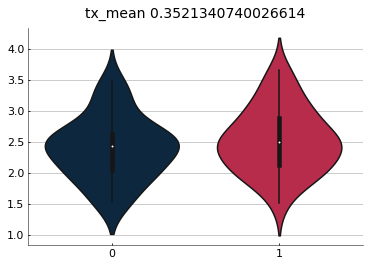

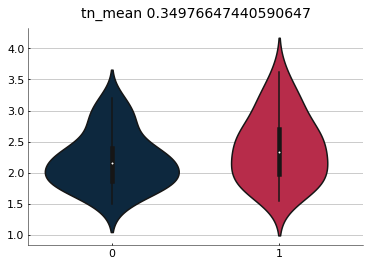

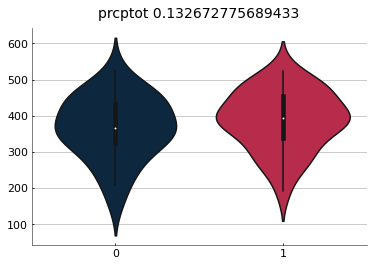

In [13]:
# f test
import scipy
def get_pvalue(group1, group2 ):
    
    # check if they have the same variance, F-test
    f = np.var(group1, ddof=1)/np.var(group2, ddof=1)
    nun = len(group1)-1
    dun = len(group2)-1
    p_value = 1-scipy.stats.f.cdf(f, nun, dun)
    if p_value >= 0.05:
        equal_var=  True 
    else:
        equal_var = False 
    
    # T-test
    pvalue=scipy.stats.ttest_ind(group1,group2, equal_var =equal_var , nan_policy='omit').pvalue
    
    return pvalue

lat= 45.5
lon=-73.5
lat=45.503895

func= {'prcptot': 'precip_accumulation',
      'tx_mean':'tx_mean',
      'tn_mean':'tn_mean'}
with xr.set_options(keep_attrs=True):
    for i,(var,title) in enumerate(zip(['tx_mean', 'tn_mean', 'prcptot'],['a)','b)', 'c)'])):
        #get variable and compute indicators
        sim_dict = pcat.search(processing_level='regridded', experiment='ssp370', domain ='QC-rdrs').to_dataset_dict()    
        sim_dict= {i: getattr(xc.atmos, func[var])(ds=ds.where(ds.lat==lat, drop=True)).drop_vars('loc').squeeze()
                   for i,ds in sim_dict.items()}
        # compute anomaly
        sim_dict = {i: ds - ds.sel(time=slice('1989','2018')).mean(dim='time') for i,ds in sim_dict.items()}
        # ensemble stats
        ens_sim = xs.ensembles.ensemble_stats(
                            datasets=sim_dict,
                            statistics={"ensemble_percentiles": {'split': False}},
                            common_attrs_only=False,
                        )[var].to_dataset()


        #same as above but for scen
        scen_dict = pcat.search(processing_level='indicators', domain='QC-rdrs',
                                variable=var, xrfreq='AS-JAN', experiment='ssp370').to_dataset_dict()
        scen_dict = {i: ds.where(ds.lat==lat, drop=True).squeeze() for i,ds in scen_dict.items()}
        scen_dict = {i: ds - ds.sel(time=slice('1989','2018')).mean(dim='time') for i,ds in scen_dict.items()}
        ens_scen = xs.ensembles.ensemble_stats(
                            datasets=scen_dict,
                            statistics={"ensemble_percentiles": {'split': False}},
                            common_attrs_only=False,
                        )[var].to_dataset()
        
        group_sim = (ens_sim.sel(percentiles=90) - ens_sim.sel(percentiles=10)).sel(time=slice('2071','2100'))
        group_scen = (ens_scen.sel(percentiles=90)-ens_scen.sel(percentiles=10)).sel(time=slice('2071','2100'))
        plt.figure()
        sns.violinplot(data =[group_sim[var],group_scen[var]])
        plt.title(f"{var} {p}")
        p=get_pvalue(group_sim[var].values, group_scen[var].values )
        print(var, p)
        

# delta

/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/spirograph/matplotlib/utils.py:633: UserWarning: No spaces, points or colons to break line at.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/spirograph/matplotlib/utils.py:633: UserWarning: No spaces, points or colons to break line at.


sim
tx_mean 4.1678944
scen
tx_mean 4.120715


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/spirograph/matplotlib/utils.py:633: UserWarning: No spaces, points or colons to break line at.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/spirograph/matplotlib/utils.py:633: UserWarning: No spaces, points or colons to break line at.


sim
tn_mean 4.3762937
scen
tn_mean 4.3788524
sim
prcptot 10.919325
scen
prcptot 13.123413


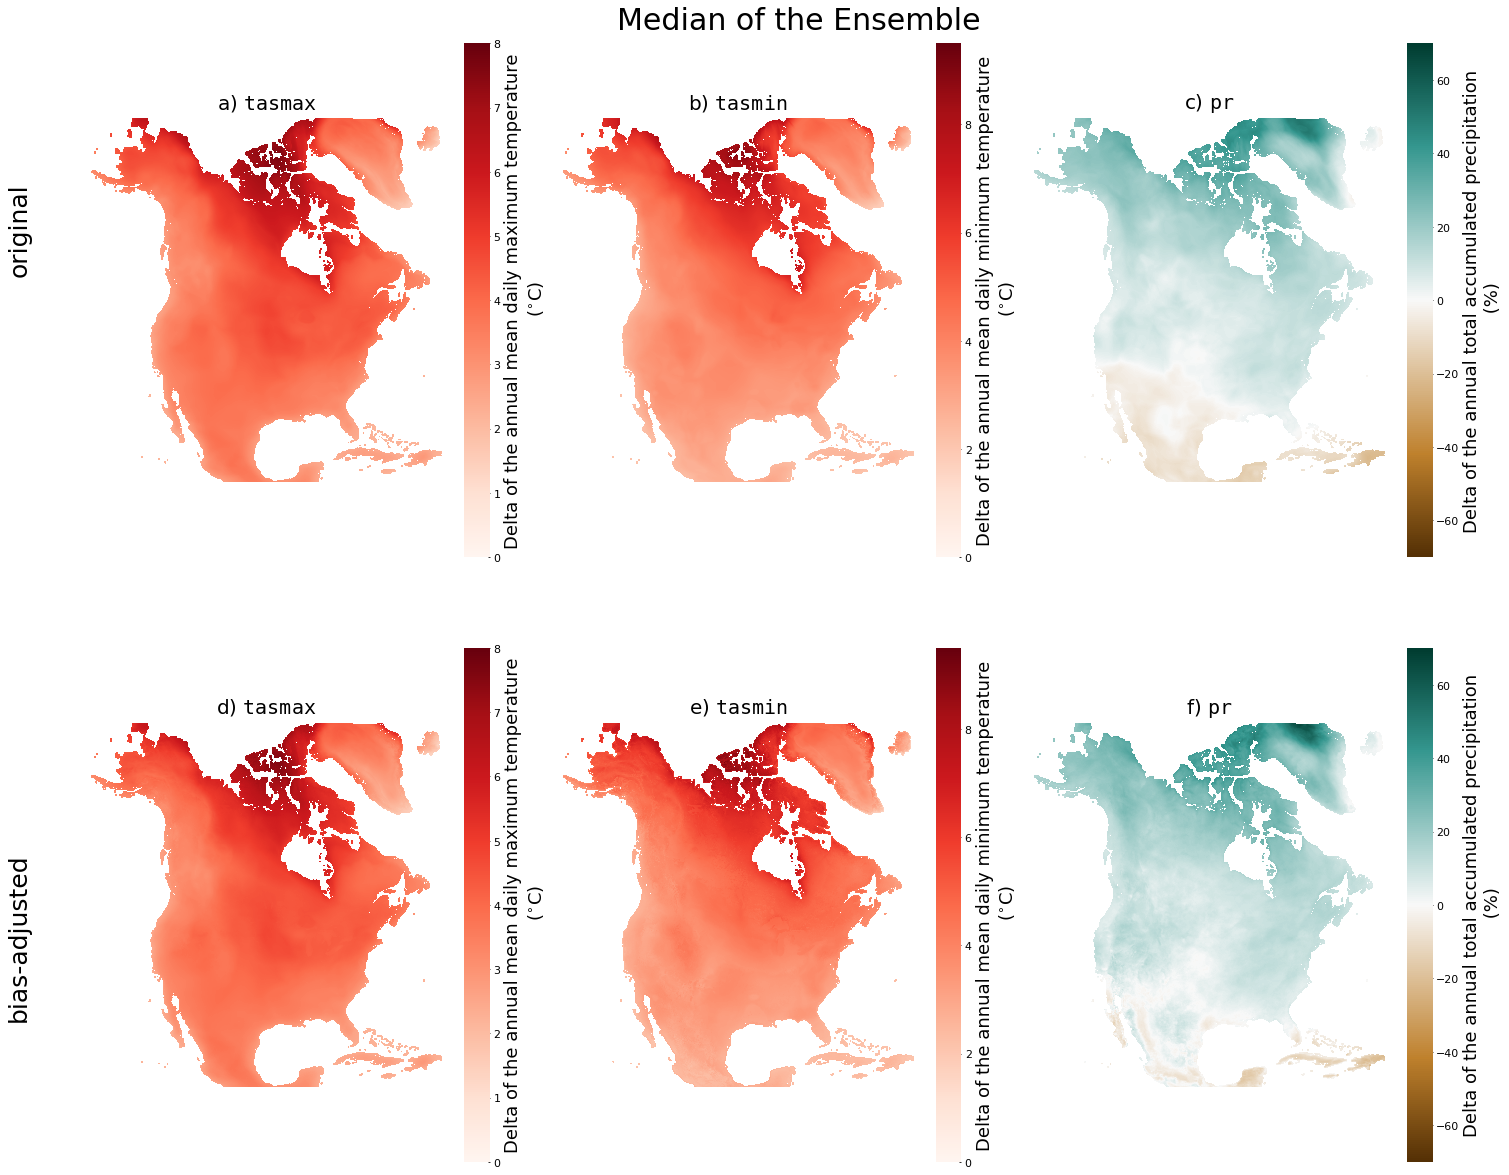

In [59]:
# mediane des deltas NAM, sim et scen. with percentage delta for pr

# sim
ds_reg_dict = pcat.search(processing_level='ensemble-reg-abs-delta-1989-2018', xrfreq='AS-JAN').to_dataset_dict()
regs=[]
for region in ['south', 'middle', 'north']:
    regs.append(xs.utils.unstack_fill_nan(
        ds_reg_dict[f'CMIP6_ScenarioMIP_ssp370_{region}-rdrs-rot.{region}-rdrs-rot.ensemble-reg-abs-delta-1989-2018.AS-JAN']))
ds_reg = xr.concat(regs, 'rlat')
ds_reg.isel(time=0)["prcptot_delta_1989_2018_p50"].plot()


#sim pr 
ds_reg_dict = pcat.search(processing_level='ensemble-reg-per-delta-1989-2018', xrfreq='AS-JAN').to_dataset_dict()
regs=[]
for region in ['south', 'middle', 'north']:
    regs.append(xs.utils.unstack_fill_nan(
        ds_reg_dict[f'CMIP6_ScenarioMIP_ssp370_{region}-rdrs-rot.{region}-rdrs-rot.ensemble-reg-per-delta-1989-2018.AS-JAN']))
ds_reg_per = xr.concat(regs, 'rlat')

#scen
ds = pcat.search(processing_level='ensemble-abs-delta-1989-2018', xrfreq='AS-JAN', domain='NAM-rdrs').to_dataset()

#scen pr
ds_per = pcat.search(processing_level='ensemble-per-delta-1989-2018', xrfreq='AS-JAN', domain='NAM-rdrs').to_dataset()


map_proj = ccrs.RotatedPole(pole_longitude=87.59703063964844,
                          pole_latitude=31.758316040039062,
                         )

p='p50'
fig, axs= plt.subplots(2,3, figsize=(20,23),subplot_kw={'projection': map_proj})


for i,(var, long_var, variable) in enumerate(zip(['tx_mean', 'tn_mean', 'prcptot'],
                                       ['mean daily maximum temperature',
                                        'mean daily minimum temperature',
                                        'total accumulated precipitation',],
                                                ['tasmax','tasmin','pr'])):
    if var =='prcptot':
        da=ds_per[f"{var}_delta_1989_2018_{p}"].sel(time='2071').squeeze().chunk({'rlat':-1, 'rlon':-1})
        da_reg=ds_reg_per[f"{var}_delta_1989_2018_{p}"].sel(time='2071').squeeze().chunk({'rlat':-1, 'rlon':-1})
        diff = da-da_reg

    else:
        
        da=ds[f"{var}_delta_1989_2018_{p}"].sel(time='2071').squeeze().chunk({'rlat':-1, 'rlon':-1})
        da_reg=ds_reg[f"{var}_delta_1989_2018_{p}"].sel(time='2071').squeeze().chunk({'rlat':-1, 'rlon':-1})
        diff = da-da_reg

    shrink=0.5
    if var =='tx_mean':
        da.attrs['units']=r"$^{\circ}$C"
        da_reg.attrs['units']=r"$^{\circ}$C"
        sp.gridmap(da_reg, ax=axs[0,i], cmap='Reds', plot_kw=dict(vmin=0, vmax=8,cbar_kwargs={'shrink':shrink}))
        sp.gridmap(da, ax=axs[1,i],  cmap='Reds', plot_kw=dict(vmin=0, vmax=8,cbar_kwargs={'shrink':shrink}))
        
    elif var =='tn_mean':
        da.attrs['units']=r"$^{\circ}$C"
        da_reg.attrs['units']=r"$^{\circ}$C"
        sp.gridmap(da_reg, ax=axs[0,i], cmap='Reds', plot_kw=dict(vmin=0, vmax=9.5,cbar_kwargs={'shrink':shrink}))
        sp.gridmap(da, ax=axs[1,i], cmap='Reds', plot_kw=dict(vmin=0, vmax=9.5,cbar_kwargs={'shrink':shrink}))

    else:
        sp.gridmap(da_reg, ax=axs[0,i], divergent=0, plot_kw=dict(vmin=-70, vmax=70,cbar_kwargs={'shrink':shrink}))
        sp.gridmap(da, ax=axs[1,i], divergent=0, plot_kw=dict(vmin=-70, vmax=70,cbar_kwargs={'shrink':shrink}))
    
    
    


    for j in range(2):
        axs[j,i].collections[-1].colorbar.outline.set_visible(False)
        axs[j,i].set_title(f'{string.ascii_lowercase[i+ (3*j)]}) '+ rf'$\tt{variable}$', fontsize=20)
        axs[j,i].collections[-1].colorbar.set_label(
            f"Delta of the annual {long_var}\n ({da.attrs['units']})", fontsize=18)
    
    print('sim')
    print(var, da_reg.mean().values)
    print('scen')
    print(var, da.mean().values)
fig.text(-0.05,0.70,r'original', fontsize=25, rotation='vertical')
fig.text(-0.05,0.25,r'bias-adjusted', fontsize=25, rotation='vertical')
fig.tight_layout(h_pad=-15)
fig.suptitle('Median of the Ensemble', fontsize=30, y=0.86)
#plt.savefig(f"{CONFIG['paths']['figures']}delta_p50.eps", format='eps',bbox_inches='tight')
plt.savefig(f"{CONFIG['paths']['figures']}delta_p50.pdf", bbox_inches='tight')

/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/spirograph/matplotlib/utils.py:633: UserWarning: No spaces, points or colons to break line at.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/spirograph/matplotlib/utils.py:633: UserWarning: No spaces, points or colons to break line at.


sim
tx_mean 2.001273
scen
tx_mean 2.0183256


/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/spirograph/matplotlib/utils.py:633: UserWarning: No spaces, points or colons to break line at.
/exec/jlavoie/.conda/espo-g/lib/python3.9/site-packages/spirograph/matplotlib/utils.py:633: UserWarning: No spaces, points or colons to break line at.


sim
tn_mean 1.8924869
scen
tn_mean 1.9204736
sim
prcptot 16.955353
scen
prcptot 17.612885


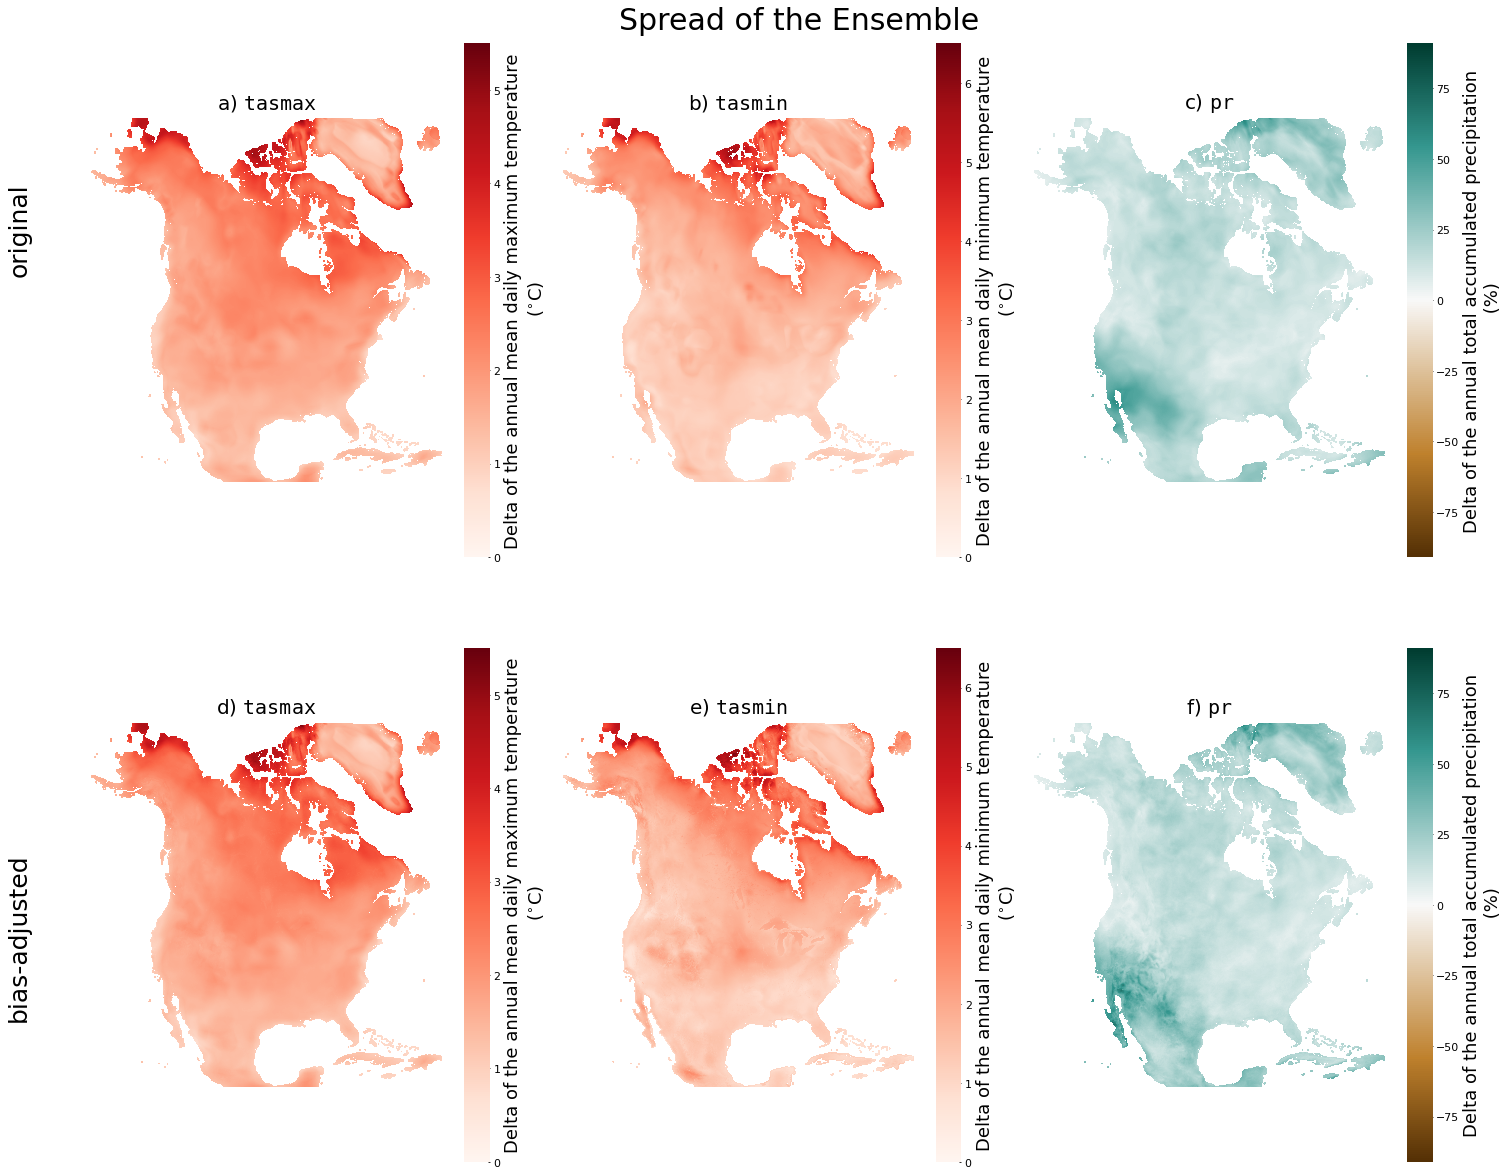

In [55]:
# # spread des deltas NAM, sim et scen


ds_reg_dict = pcat.search(processing_level='ensemble-reg-abs-delta-1989-2018', xrfreq='AS-JAN').to_dataset_dict()
regs=[]
for region in ['south', 'middle', 'north']:
    regs.append(xs.utils.unstack_fill_nan(
        ds_reg_dict[f'CMIP6_ScenarioMIP_ssp370_{region}-rdrs-rot.{region}-rdrs-rot.ensemble-reg-abs-delta-1989-2018.AS-JAN']))
ds_reg = xr.concat(regs, 'rlat')


#sim pr 
ds_reg_dict = pcat.search(processing_level='ensemble-reg-per-delta-1989-2018', xrfreq='AS-JAN').to_dataset_dict()
regs=[]
for region in ['south', 'middle', 'north']:
    regs.append(xs.utils.unstack_fill_nan(
        ds_reg_dict[f'CMIP6_ScenarioMIP_ssp370_{region}-rdrs-rot.{region}-rdrs-rot.ensemble-reg-per-delta-1989-2018.AS-JAN']))
ds_reg_per = xr.concat(regs, 'rlat')

#scen
ds = pcat.search(processing_level='ensemble-abs-delta-1989-2018', xrfreq='AS-JAN', domain='NAM-rdrs').to_dataset()

#scen pr
ds_per = pcat.search(processing_level='ensemble-per-delta-1989-2018', xrfreq='AS-JAN', domain='NAM-rdrs').to_dataset()


map_proj = ccrs.RotatedPole(pole_longitude=87.59703063964844,
                          pole_latitude=31.758316040039062,
                         )


#fig, axs= plt.subplots(3,3, figsize=(20,25),subplot_kw={'projection': map_proj})
fig, axs= plt.subplots(2,3, figsize=(20,23),subplot_kw={'projection': map_proj})


for i,(var, long_var, variable) in enumerate(zip(['tx_mean', 'tn_mean', 'prcptot'],
                                       ['mean daily maximum temperature',
                                        'mean daily minimum temperature',
                                        'total accumulated precipitation',],
                                                ['tasmax','tasmin','pr'])):
    with xr.set_options(keep_attrs=True):
        if var =='prcptot':
            da=(ds_per[f"{var}_delta_1989_2018_p90"]- ds_per[f"{var}_delta_1989_2018_p10"]).sel(time='2071').squeeze().chunk({'rlat':-1, 'rlon':-1})
            da_reg=(ds_reg_per[f"{var}_delta_1989_2018_p90"]-ds_reg_per[f"{var}_delta_1989_2018_p10"]).sel(time='2071').squeeze().chunk({'rlat':-1, 'rlon':-1})
            diff = da-da_reg

        else:

            da=(ds[f"{var}_delta_1989_2018_p90"]-ds[f"{var}_delta_1989_2018_p10"]).sel(time='2071').squeeze().chunk({'rlat':-1, 'rlon':-1})
            da_reg=(ds_reg[f"{var}_delta_1989_2018_p90"]-ds_reg[f"{var}_delta_1989_2018_p10"]).sel(time='2071').squeeze().chunk({'rlat':-1, 'rlon':-1})
            diff = da-da_reg
    shrink=0.5
    if var == 'tx_mean':
        da.attrs['units']=r"$^{\circ}$C"
        da_reg.attrs['units']=r"$^{\circ}$C"
        sp.gridmap(da_reg, ax=axs[0,i], cmap='Reds', plot_kw=dict(vmin=0, vmax=5.5,cbar_kwargs={'shrink':shrink}))
        sp.gridmap(da, ax=axs[1,i], cmap='Reds', plot_kw=dict(vmin=0, vmax=5.5,cbar_kwargs={'shrink':shrink}))
    elif var =='tn_mean':
        da.attrs['units']=r"$^{\circ}$C"
        da_reg.attrs['units']=r"$^{\circ}$C"
        sp.gridmap(da_reg, ax=axs[0,i], cmap='Reds', plot_kw=dict(vmin=0, vmax=6.5,cbar_kwargs={'shrink':shrink}))
        sp.gridmap(da, ax=axs[1,i], cmap='Reds', plot_kw=dict(vmin=0, vmax=6.5,cbar_kwargs={'shrink':shrink}))
    
    else:
        sp.gridmap(da_reg, ax=axs[0,i], divergent=0, plot_kw=dict(vmin=-91, vmax=91,cbar_kwargs={'shrink':shrink}))
        sp.gridmap(da, ax=axs[1,i], divergent=0, plot_kw=dict(vmin=-91, vmax=91,cbar_kwargs={'shrink':shrink}))
    
    
    


    for j in range(2):
        axs[j,i].collections[-1].colorbar.outline.set_visible(False)
        axs[j,i].set_title(f'{string.ascii_lowercase[i+ (3*j)]}) '+ rf'$\tt{variable}$', fontsize=20)
        axs[j,i].collections[-1].colorbar.set_label(
            f"Delta of the annual {long_var}\n ({da.attrs['units']})", fontsize=18)
    
    print('sim')
    print(var, da_reg.mean().values)
    print('scen')
    print(var, da.mean().values)
fig.text(-0.05,0.70,r'original', fontsize=25, rotation='vertical')
fig.text(-0.05,0.25,r'bias-adjusted', fontsize=25, rotation='vertical')
fig.tight_layout(h_pad=-15)
fig.suptitle('Spread of the Ensemble',fontsize=30, y=0.86)
plt.savefig(f"{CONFIG['paths']['figures']}delta_p1090.eps", format='eps',bbox_inches='tight')